In [35]:
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import f1_score
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from logistic_regression import logistic
from scipy.stats.mstats import mquantiles
import seaborn as sns
import scipy.stats
from plot_utils import PlotInfo, save_freq_acc_plot_and_get_info, save_logistic_regression_lines_plot_for_shots, save_logistic_regression_lines_plot_for_models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
sns.set_theme(style="white", palette="pastel")

In [4]:
def lin_reg(X, y):
    X = X.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    reg.fit(X, y)
    print(reg.coef_, reg.intercept_)

In [5]:
def find_frequency(row, second_str, WORD, freq_dict):
    not_found = 0
    num_2_key = ""
    num_2_frequency = 0
    min_val = min(str(row['testcase.data_point.frequency_data.x']), str(row[f'testcase.data_point.frequency_data.{second_str}']))
    max_val = max(str(row['testcase.data_point.frequency_data.x']), str(row[f'testcase.data_point.frequency_data.{second_str}']))
    if WORD in ['mult', 'plus']:
        tuple1 = (min_val, max_val)
        tuple2 = (max_val, min_val)
    else:
        tuple1 = (min_val, max_val, WORD)
        tuple2 = (max_val, min_val, WORD)
    if tuple1 in freq_dict.keys() and tuple2 in freq_dict.keys() and not (tuple1 == tuple2):
            print(f"something is very wrong!!!!!!!!!!! tuple1: {tuple1} tuple2: {tuple2}")
    if tuple1 in freq_dict.keys():
        num_2_key = str(tuple1)
        num_2_frequency = freq_dict[tuple1]
    elif tuple2 in freq_dict.keys():
        num_2_key = str(tuple2)
        num_2_frequency = freq_dict[tuple2]
    else:
        num_2_key = str(tuple1)
        not_found = 1
    return num_2_key, num_2_frequency, not_found

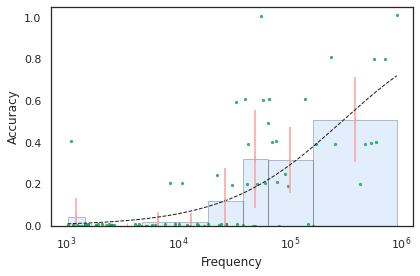

2 : 0.13535353535353536


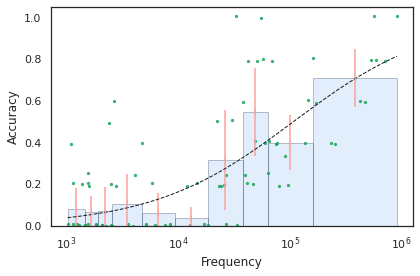

4 : 0.24123711340206186


FileNotFoundError: [Errno 2] No such file or directory: './results2/results/num1_week_top200_gptj_8shots_5seeds_results.csv'

In [46]:
WORD = 'week'
MODEL = 'gptj'
for shots in [2, 4, 8, 20]:
    a = save_freq_acc_plot_and_get_info(WORD, shots, MODEL, key='x', show_plot = True)
    print(shots, ":", a.accuracy_all)


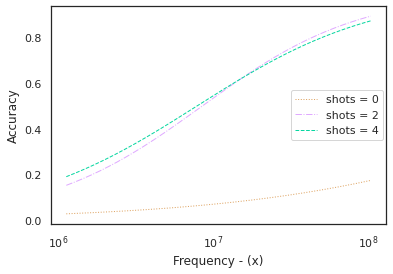

In [45]:
save_logistic_regression_lines_plot_for_shots('mult', 'gptj', shots=[0,2,4], key='x', show_plot=True)


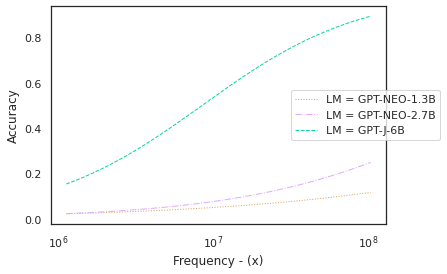

In [47]:
save_logistic_regression_lines_plot_for_models('mult', ['gptjsmall', 'gptjlarge', 'gptj'], shot=2, key='x', show_plot=True)

/home/yrazeghi/miniconda3/envs/GPTJ-proc/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


100
100
5098
0 5098
5098 10196
10196 15294
15294 20392
20392 25490
[1.6139811  1.1118515  1.32505553 0.73022784 0.42459632]


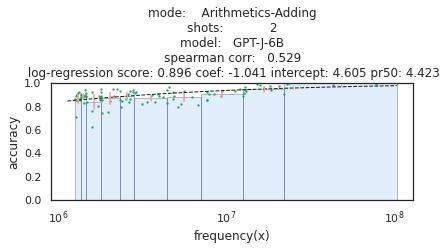

In [16]:
#Just frequency of x:
FREQ_NUM=1
WORD='plus' #mult, #plus or time_units #concat mode10# #plushashtag 'compareless'
WORD_FLAG = False
TOP_FREQ = 200
MODEL = 'gptj' #can be 'gptjsmall' 'gptjlarge'
SHOTS = 2 # 2

if WORD in ['mult', 'plus', 'concat', 'plushashtag']:
    file_name = f'./results2/results/num{FREQ_NUM}_{WORD}_1to50_top{TOP_FREQ}_{MODEL}_{SHOTS}shots_5seeds_results.csv'
elif WORD in ['compareless', 'comparemore']:
    file_name = f'./results2/results/num{FREQ_NUM}_{WORD}_1to100_top{TOP_FREQ}_{MODEL}_{SHOTS}shots_5seeds_results.csv'
else:
    file_name = f'./results2/results/num{FREQ_NUM}_{WORD}_top{TOP_FREQ}_{MODEL}_{SHOTS}shots_5seeds_results.csv'
data_file = pd.read_csv(file_name)
data_file.replace(True, 1, inplace=True)
data_file.replace(False,0, inplace=True)

aggregated_by_key = data_file.groupby('testcase.data_point.frequency_data.key')['is_correct', 'testcase.data_point.frequency_data.frequency'].mean()
# aggregated_by_key.plot(kind='scatter', x='testcase.data_point.frequency_data.frequency', y='is_correct')
spearman_correlation = aggregated_by_key.corr(method='spearman')
sp_corr = spearman_correlation.loc['is_correct', 'testcase.data_point.frequency_data.frequency']


frequencies = aggregated_by_key['testcase.data_point.frequency_data.frequency'].to_numpy()
print(len(frequencies))
is_correct = aggregated_by_key['is_correct'].to_numpy()
print(len(is_correct))
quantiles, accuracies, widths ,h, mid_quantiles = quantile_accuracies_plot(frequencies, is_correct, q_num=10)
#plotting the bars
plt.xscale('log')
plt.bar(quantiles[:-1], height=accuracies, width=widths, align='edge', alpha=0.3, edgecolor='#182e52')
plt.errorbar(mid_quantiles, accuracies, yerr=h ,fmt="|", color="r" )

#for fitting a linear regression:
# print("****************")
# lin_reg(np.log10(mid_quantiles), accuracies)


#for fitting a logistic regression
freq_all = data_file['testcase.data_point.frequency_data.frequency'].to_numpy()
accuracy_all = data_file['is_correct'].to_numpy()

frequencies_log10 = np.log10(freq_all)
len_all = int(len(frequencies_log10)/5)
print(len_all)
coeffs = np.zeros(shape=(5,))  
inters = np.zeros(shape=(5,))
scores = np.zeros(shape=(5,))
for i in range(5):
    s_division = i*len_all
    e_division = (i+1)*len_all
    print(s_division, e_division)
    scores[i], coeffs[i], inters[i] = log_reg_fit(frequencies_log10[s_division:e_division], accuracy_all[s_division:e_division])
print(coeffs)
coef = np.mean(coeffs)
intercept = np.mean(inters)
mean_score = np.mean(scores)
t = np.linspace(frequencies_log10.min(), frequencies_log10.max(), 10000)[:, None]
p_t = logistic(t.T, -coef, -intercept)
t = np.power(10, t)
plt.plot(t[:,0], p_t[0,:], lw=1, ls="--", color="k",
         label="average posterior \nprobability of correctness")
sns.regplot(data=aggregated_by_key, x='testcase.data_point.frequency_data.frequency', y='is_correct', scatter=True, fit_reg=False, scatter_kws={"color": "#18A558", "s":2}, x_jitter=0.01, y_jitter=0.01)
if MODEL == 'gptjsmall':
    model_name = 'GPT-NEO-1.3B'
elif MODEL == 'gptjlarge':
    model_name = 'GPT-NEO-2.7B'
elif MODEL == 'gptj':
    model_name = 'GPT-J-6B'
if WORD == 'mult' and WORD_FLAG==False:
    MODE = 'Arithmetics-Multiplication'
elif WORD == 'plus' and WORD_FLAG==False:
    MODE = 'Arithmetics-Adding'
elif WORD == 'concat' and WORD_FLAG==False:
    MODE = 'Numbers-Concatination'
elif WORD == 'mode10hashtag' and WORD_FLAG==False:
    MODE = 'Numbers-Mode10#'
elif WORD == 'plushashtag' and WORD_FLAG==False:
    MODE = 'Numbers-Add#'
elif WORD == 'compareless' and WORD_FLAG==False:
    MODE = 'Numbers-lower'
elif WORD == 'comparemore' and WORD_FLAG==False:
    MODE = 'Numbers-higher'
else:
    MODE = f'Time-Coversion-From{WORD}'
plt.title(f'mode:    {MODE}\n' 
          f'shots:            {SHOTS}\n'
          f'model:   {model_name}\n'
          f'spearman corr:   {sp_corr:.3f}\n log-regression score: {mean_score:.3f} coef: {-coef:.3f} intercept: {-intercept:.3f} pr50: {(-intercept / coef):.3f}') #' \nlog_reg_intercept:  {-log_inter:.3f}\n', loc=left)
plt.xlabel('frequency(x)')
plt.ylabel('accuracy')
plt.tight_layout()
plt.subplots_adjust(top=0.60 )
plt.ylim([0, 1])
plt.savefig(f'./figures2/{MODE}_{SHOTS}shots_{model_name}.png', format='png', dpi=500)
plt.show()

In [ ]:
result = ""
digit_limit = 2
num_2_frequency_dic = {}
start = time.time()
with open("./num2_counts/num_2_counting.txt") as f:
    for line in f.readlines():
        key, frequency = eval(line)
        if len(key[0]) <= digit_limit or len(key[1]) <= digit_limit:
            num_2_frequency_dic[key] = frequency

print(
    f"done with readint the frequency here is read and it took {time.time() - start} seconds {type(num_2_frequency_dic)}")

In [ ]:
FREQ_NUM = 1  # can be 1 2 3
WORD = 'mult'  # mult, #plus
WORD_FLAG = False
TOP_FREQ = 200
MODEL = 'gptj'  # can be 'gptjsmall' 'gptjlarge'
SHOTS = 4

# file_name = f'/home/yrazeghi/PHD/TYM/GPTAnalyzer/results/num{FREQ_NUM}_{WORD}_top{TOP_FREQ}_{MODEL}_{SHOTS}shots_5seeds_results.csv'
file_name = f'./results/num{FREQ_NUM}_{WORD}_1to50_top{TOP_FREQ}_{MODEL}_{SHOTS}shots_5seeds_results.csv'
data_file = pd.read_csv(file_name)
not_found = 0
for i, row in data_file.iterrows():
    num_2_key = ""
    num_2_frequency = 0
    min_val = min(str(row['testcase.data_point.frequency_data.x']), str(row['testcase.data_point.frequency_data.z']))
    max_val = max(str(row['testcase.data_point.frequency_data.x']), str(row['testcase.data_point.frequency_data.z']))
    
    tuple1 = (min_val, max_val)
    tuple2 = (max_val, min_val)
    if tuple1 in num_2_frequency_dic.keys() and tuple2 in num_2_frequency_dic.keys() and not (tuple1 == tuple2):
        print(f"something is very wrong!!!!!!!!!!! tuple1: {tuple1} tuple2: {tuple2}")
    if tuple1 in num_2_frequency_dic.keys():
        num_2_key = str(tuple1)
        num_2_frequency = num_2_frequency_dic[tuple1]
    elif tuple2 in num_2_frequency_dic.keys():
        num_2_key = str(tuple2)
        num_2_frequency = num_2_frequency_dic[tuple2]
    else:
        num_2_key = str(tuple1)
        not_found = not_found + 1
    data_file.at[i, 'num_2_key'] = num_2_key
    data_file.at[i, 'num_2_frequency'] = num_2_frequency
print(f"not found number is {not_found}")
sns.set_theme(style="white", palette="pastel")
frequencies = data_file['num_2_frequency'].to_numpy()

# This is the y data
is_correct = data_file['is_correct'].to_numpy()
quantiles, accuracies, widths ,h, mid_quantiles = quantile_accuracies_plot(frequencies, is_correct, q_num=10)
#plotting the bars
plt.xscale('log')
plt.bar(quantiles[:-1], height=accuracies, width=widths, align='edge', alpha=0.2)
plt.errorbar(mid_quantiles, accuracies, yerr=h ,fmt=".", color="r" )
#for fitting a logistic regression
frequencies_log10 = np.log10(frequencies)
log_score, log_coef, log_inter = log_reg_fit(frequencies_log10, is_correct)
t = np.linspace(frequencies_log10.min(), frequencies_log10.max()+1, 10000)[:, None]
p_t = logistic(t.T, -log_coef, -log_inter)
t = np.power(10, t)
plt.plot(t[:,0], p_t[0,:], lw=1, ls="--", color="k",
         label="average posterior \nprobability of correctness")
sns.regplot(data=aggregated_by_key, x='num_2_frequency', y='is_correct', scatter=True, fit_reg=False, scatter_kws={"color": "#e9c46a", "s":1}, x_jitter=0.02, y_jitter=0.02)

plt.savefig('./tmp.png', dpi=500)